# BTC TSA


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'#输出矢量图设置
from scipy import stats
import statsmodels.api as sm
import pandas_datareader.data as web
from itertools import product
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
start = '2017-01-01'
end = '2022-06-30'
data = web.DataReader('BTC-USD','yahoo',start,end)[['Adj Close']]
data.info()
df = data.copy()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2008 entries, 2017-01-01 to 2022-07-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2008 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [3]:
df.describe()

,Adj Close
count,2008.000000
mean,17431.293509
std,17460.684203
min,777.757019
25%,6224.059937
50%,9218.806152
75%,30235.004883
max,67566.828125


Construct monthly, quarterly, annually data

In [4]:
# df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

Plot to select soomthest data

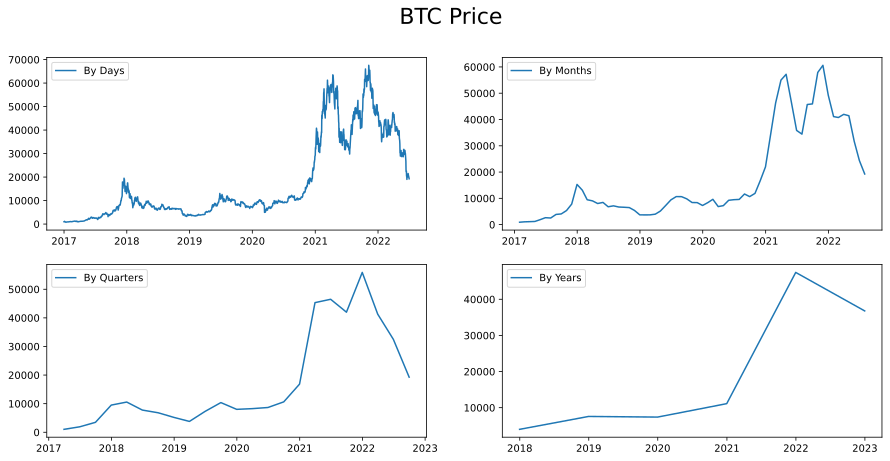

In [5]:
# PLOTS
fig = plt.figure(figsize=(15,7),dpi=360)
plt.suptitle('BTC Price', fontsize=22)

plt.subplot(221)
plt.plot(df, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

According to the 4 plots, monthly data is the soomthest data, which can be used to model.

Next step:

Check stationarity, seasonality, trendency

Dickey–Fuller test: p=0.480745
Non-stationary


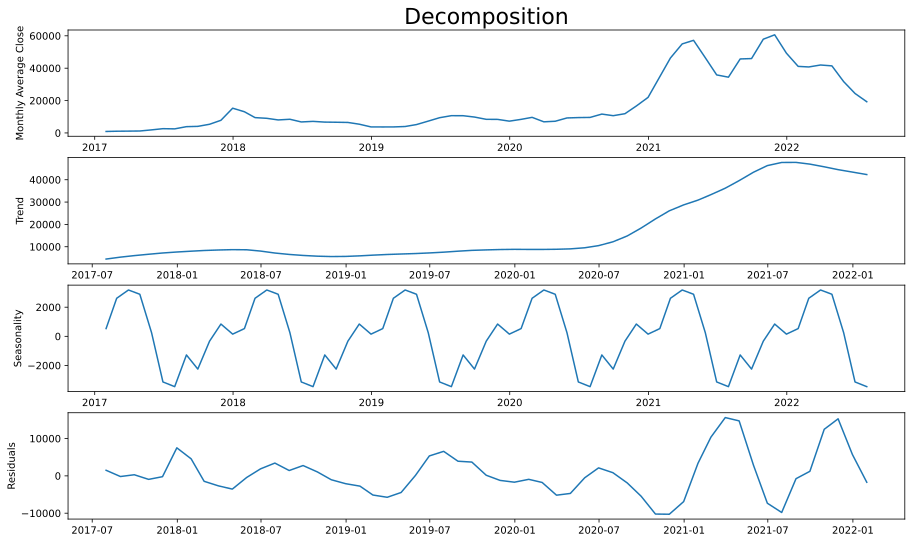

In [6]:
adf = sm.tsa.stattools.adfuller(df_month['Adj Close'])[1]
print("Dickey–Fuller test: p=%f" % adf)
if adf<=0.05:
    print('Stationary')
else:
    print('Non-stationary')


res = sm.tsa.seasonal_decompose(df_month['Adj Close'])
plt.figure(figsize=(15,9), dpi=240)

plt.subplot(4,1,1)
plt.plot(res.observed)
plt.title('Decomposition',fontsize=22)
plt.ylabel('Monthly Average Close')
plt.subplot(4,1,2)
plt.plot(res.trend)
plt.ylabel('Trend')
plt.subplot(4,1,3)
plt.plot(res.seasonal)
plt.ylabel('Seasonality')
plt.subplot(4,1,4)
plt.plot(res.resid)
plt.ylabel('Residuals')
plt.show()


According to the ADF-test P-value(=0.48>>0.05), monthly data is not stationary.

According to the decomposition, the monthly data contains trend and seasonality.

In [7]:
r = np.log(df['Adj Close']).diff()

P-value of normal test=0.001850379018128327


<Figure size 720x480 with 0 Axes>

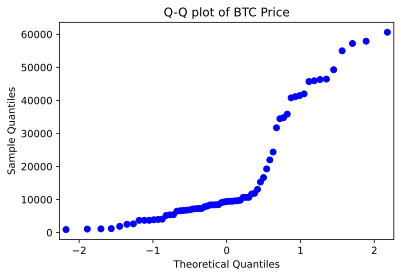

In [8]:
from scipy.stats import normaltest
print('P-value of normal test={}'.format(normaltest(df_month['Adj Close'])[1]))
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(6,4),dpi=120)
qqplot(df_month['Adj Close'])
plt.title('Q-Q plot of BTC Price')
plt.show()

According to the qq-plot, datapoints are not on the diagonal, which means monthly data is not normal distributed.
Furthermore, the P-value of normal test<0.01. In other words, we can reject the normal distributed hypothsis.

One simple idea is taking the logrithm or sqrt of the monthly data.

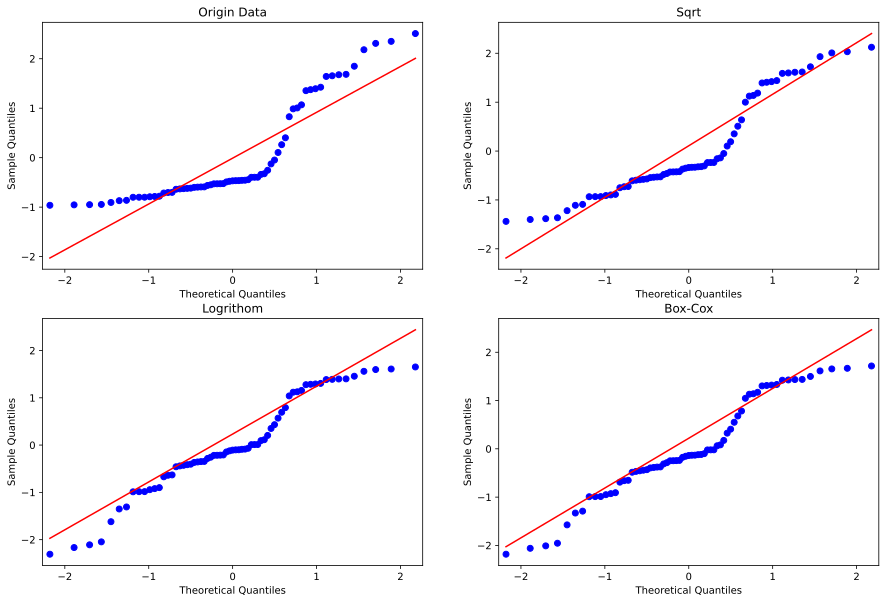

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax= axes.flatten()
qqplot(df_month['Adj Close'], fit = True, line='q', ax=ax[0])
ax[0].title.set_text('Origin Data')

df_month['sqrt_price'] = np.sqrt(df_month['Adj Close'])
qqplot(df_month['sqrt_price'], fit = True, line='q', ax=ax[1])
ax[1].title.set_text('Sqrt')

df_month['log_price'] = np.log(df_month['Adj Close'])
qqplot(df_month['log_price'], fit = True, line='q', ax=ax[2])
ax[2].title.set_text('Logrithom')

df_month['box_price'], lmbda = stats.boxcox(df_month['Adj Close'])
qqplot(df_month['box_price'], fit = True, line='q', ax=ax[3])
ax[3].title.set_text('Box-Cox')
plt.show() 

In [10]:
# original 
print('P-value of normal test={}'.format(normaltest(df_month['Adj Close'])[1]))

# sqrt transformation
print('P-value of normal test for sqrt of  data: {}'.format(normaltest(df_month['sqrt_price'])[1]))

# logrithm transformation
print('P-value of normal test for log of data: {}'.format(normaltest(df_month['log_price'])[1]))

# Box-Cox Transformation
print('Box-Cox Transformation lmbda={}'.format(lmbda))
print('P-value of normal test for Box-Cox transformed  data: {}'.format(normaltest(df_month['box_price'])[1]))


P-value of normal test=0.001850379018128327
P-value of normal test for sqrt of  data: 0.01552276565755773
P-value of normal test for log of data: 0.6970619002883531
Box-Cox Transformation lmbda=0.06075538765140273
P-value of normal test for Box-Cox transformed  data: 0.5625267475909694


Comparing the there transformation, we can find the Box-Cox transformation has the best normalality. 

Thus, we choose Box-Cox transformed data with $\lambda$ = 0.15. 
\begin{equation}
x_{\text{transform}}(\lambda)= \begin{cases}\frac{x^\lambda-1}{\lambda}, & \lambda \neq 0 \\ \ln x, & \lambda=0\end{cases}
\end{equation}

The next step is to remove the seasonality and trend.

In [11]:
print("P-value of ADF-test for transformed data: %f" % sm.tsa.stattools.adfuller(df_month['log_price'])[1])

P-value of ADF-test for transformed data: 0.181825


ADF-test indicate that the transformed data are not stationary. Then we can difference the transformed data.

In [12]:
# Seasonal differentiation
df_month['log_price_seasonal_diff'] = df_month['log_price'] - df_month['log_price'].shift(12)
print("P-value of ADF-test for seasonal differenced transformed data: %f" % sm.tsa.stattools.adfuller(df_month['log_price_seasonal_diff'][12:])[1])

# Seasonal & Regular differentiation
df_month['log_price_r&s_diff'] = df_month['log_price_seasonal_diff'] - df_month['log_price_seasonal_diff'].shift(1)
print("P-value of ADF-test for seasonal & regular differenced transformed data: %f" % sm.tsa.stattools.adfuller(df_month['log_price_r&s_diff'][13:])[1])

P-value of ADF-test for seasonal differenced transformed data: 0.175404
P-value of ADF-test for seasonal & regular differenced transformed data: 0.000576


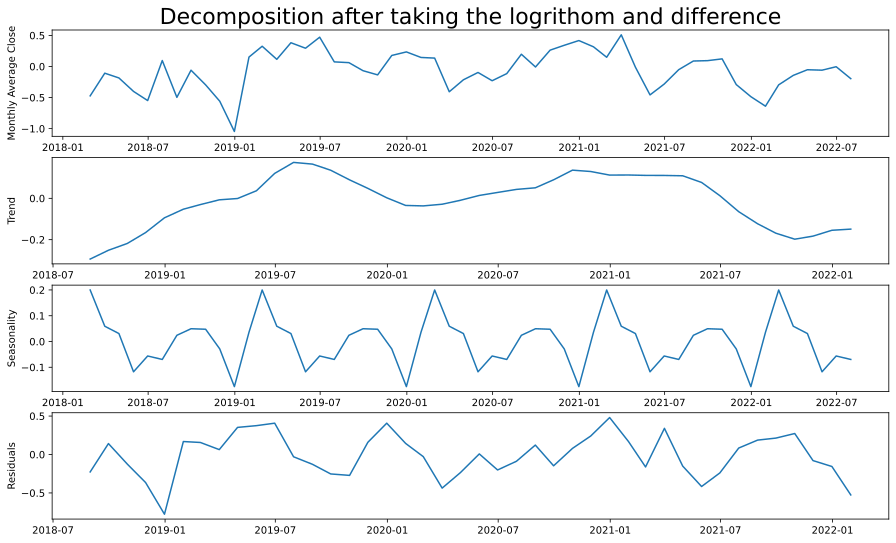

In [13]:
# STL-decomposition
res = sm.tsa.seasonal_decompose(df_month['log_price_r&s_diff'][13:])
plt.figure(figsize=(15,9), dpi=240)

plt.subplot(4,1,1)
plt.plot(res.observed)
plt.title('Decomposition after taking the logrithom and difference',fontsize=22)
plt.ylabel('Monthly Average Close')
plt.subplot(4,1,2)
plt.plot(res.trend)
plt.ylabel('Trend')
plt.subplot(4,1,3)
plt.plot(res.seasonal)
plt.ylabel('Seasonality')
plt.subplot(4,1,4)
plt.plot(res.resid)
plt.ylabel('Residuals')
plt.show()
#通过boc-cox转化，季节性差分和一阶常规差分 去除季节性，趋势项，平稳

After difference, the data is stationary(P-value=0.000576)

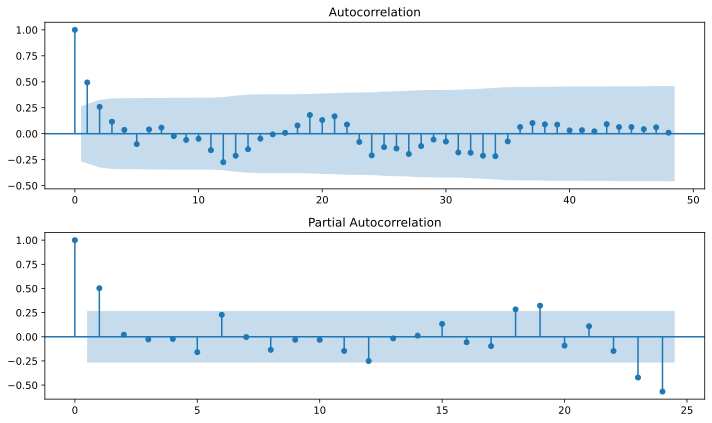

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(10,6))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month['log_price_r&s_diff'][13:], lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month['log_price_r&s_diff'][13:], lags=24, ax=ax)
plt.tight_layout()
plt.show()

According to the ACF and PACF plots, it's not cut off, thus we may need to construct an ARMA model for the stationary transformed data.

In [15]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
from tqdm import tqdm
for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(df_month['log_price'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

100%|██████████| 54/54 [00:21<00:00,  2.46it/s]


In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters       aic
19  (1, 0, 0, 1)  7.785715
22  (1, 0, 2, 0)  8.020559
23  (1, 0, 2, 1)  9.088270
7   (0, 1, 0, 1)  9.706131
21  (1, 0, 1, 1)  9.708601
                                      SARIMAX Results                                       
Dep. Variable:                            log_price   No. Observations:                   67
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  -0.893
Date:                              Sun, 11 Dec 2022   AIC                              7.786
Time:                                      19:32:36   BIC                             13.753
Sample:                                  01-31-2017   HQIC                            10.087
                                       - 07-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

According to AIC, the best model is $Seasonal\ ARIMA(1,1,0) \times (0,1,1)_{12}$.

Specifically, in the form of:

$\Phi(B^{12})\phi(B)\nabla_{12}\nabla X_t = \Theta(B^{12})\theta(B) \omega_t$

$(1-0.4618B)\nabla_{12}\nabla X_t = (1+0.8668B^{12}) \omega_t$,where  $\sigma_{\omega}^2=0.0466$

P-value of Box-Ljung test of the model residuals(lags=6): 0.9983214405217806
P-value of Box-Ljung test of the model residuals(lags=12): 0.15321305175414945


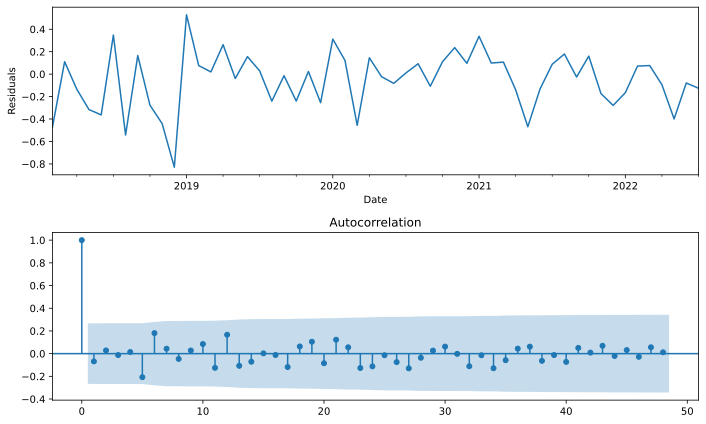

In [17]:
print('P-value of Box-Ljung test of the model residuals(lags=6): {}'.format(sm.stats.acorr_ljungbox(best_model.resid, lags=[6])[1][0]))
print('P-value of Box-Ljung test of the model residuals(lags=12): {}'.format(sm.stats.acorr_ljungbox(best_model.resid, lags=[12])[1][0]))

# STL-decomposition
plt.figure(figsize=(10,6))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:], lags=48, ax=ax)

# print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
plt.tight_layout()
plt.show()

# Check goodness of the best model
The residuals of the best model is a white noise according to the Box-Ljung test at lags=6,12, which means the model is good.

# Prediction
5-step ahead prediction

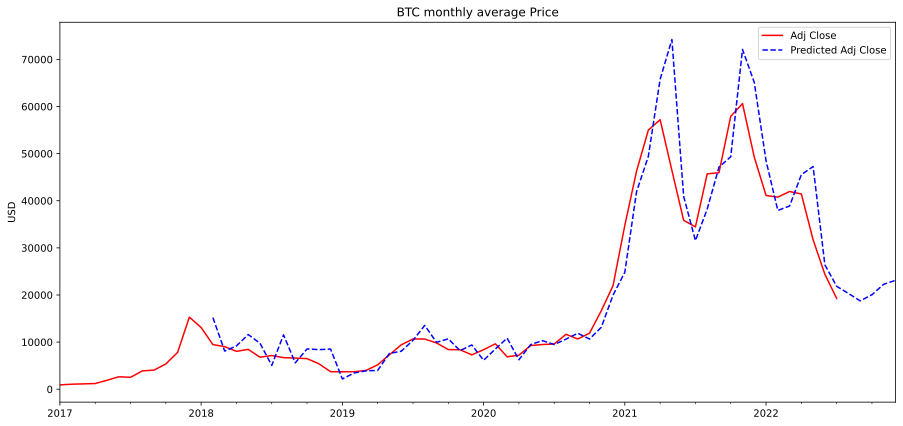

In [18]:
fore_date = np.array([datetime(2022,8,31), datetime(2022,9,30), datetime(2022,10,31), datetime(2022,11,30), datetime(2022,12,31)])
future = pd.DataFrame(index=fore_date, columns= ['forecast'])
pred = pd.concat([df_month[['Adj Close']], future])
pred['forecast'] = np.exp(best_model.predict(start=0, end=pred.shape[0]))
plt.figure(figsize=(15,7))
pred['Adj Close'].plot(color='r')
pred['forecast'][13:].plot(color='b', ls='--', label='Predicted Adj Close')
plt.legend()
plt.title('BTC monthly average Price')
plt.ylabel('USD')
plt.show()

In [21]:
pred[['forecast']].iloc[-5:]

,forecast
2022-08-31,20328.632567
2022-09-30,18746.101395
2022-10-31,20055.313016
2022-11-30,22274.449321
2022-12-31,23107.180892
